# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
!pip install -e ..

Obtaining file:///home/leo.andeol/envs/cods_13/cods
  Installing build dependencies ... 

done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for cods (pyproject.toml) ... done
  Created wheel for cods: filename=cods-0.1-0.editable-py3-none-any.whl size=2530 sha256=049b2cafc5edbdbc8f2c07eaf8e6d25334c8c656b8d6c2f555fed21ec276c0f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-4na00v45/wheels/8a/18/3d/7480853efd64323b3c6fe70b2184b40561abbfafe9ce527d31
Successfully built cods
  Attempting uninstall: cods
    Found existing installation: cods 0.1
    Uninstalling cods-0.1:
      Successfully uninstalled cods-0.1


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from cods.od.data import MSCOCODataset
from cods.od.models import DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # chose the GPU. If only one, then "0"

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [4]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [5]:
calibration_ratio = 0.5  # set 0.5 to use 50% for calibration and 50% for testing

use_smaller_subset = (
    False  # set to True to use a smaller subset of the data for calibration and testing
)

if use_smaller_subset:
    data_cal, data_val = data.random_split(
        calibration_ratio, shuffled=True, n_calib_test=800
    )
else:
    data_cal, data_val = data.random_split(calibration_ratio, shuffled=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
detr = DETRModel(model_name="detr_resnet50", pretrained=True)

print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 2500
len(data_val) = 2500


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [6]:
preds_cal = detr.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    # force_recompute=True,
)
preds_val = detr.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    # force_recompute=True,
)

Loading predictions from ./saved_predictions/detr_resnet50/mscoco/cal/predictions_object_detection.pkl
Predictions already exist, loading them...
Loading predictions from ./saved_predictions/detr_resnet50/mscoco/test/predictions_object_detection.pkl
Predictions already exist, loading them...


# 3. Test Conformal Prediction

In [7]:
from cods.od.cp import ODConformalizer

odc = ODConformalizer(
    localization_method="min-hausdorff-additive",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)

/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
cal_output = odc.calibrate(preds_cal, alpha=0.1)

2500it [00:54, 45.56it/s]


Using lbd_plus
Calibrated quantile: 0.989214301109314
Quantiles
Confidence: 0.9379606246948242
Localization: [tensor(38.9749, device='cuda:0'), tensor(38.9749, device='cuda:0'), tensor(38.9749, device='cuda:0'), tensor(38.9749, device='cuda:0')]
Classification: 0.989214301109314


In [9]:
conf_boxes, conf_cls = odc.conformalize(preds_val)

In [10]:
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

100%|██████████| 2500/2500 [00:06<00:00, 394.75it/s]

Confidence:
	 Coverage: 0.97
	 Mean Set Size: 24.96
Localization:
	 Coverage: 0.99
	 Mean Set Size: 304.08
Classification:
	 Coverage: 0.97
	 Mean Set Size: 78.96
Global:
	 Coverage: 0.92


In [11]:
from cods.od.cp import SeqODRiskConformalizer

odc = SeqODRiskConformalizer(
    localization_method="boxwise",
    objectness_method=None,
    confidence_threshold=0.1544,
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

[22.71, 22.95] -> [22.8271484375]. Corrected Risk = 0.05: 100%|██████████| 13/13 [01:02<00:00,  4.80s/it]


Using lbd_plus
Calibrated quantile: 0.9892140626907349
Quantiles
Localization: 22.8271484375
Classification: 0.9892140626907349


RuntimeError: stack expects each tensor to be equal size, but got [] at entry 0 and [1] at entry 2406

In [12]:
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

100%|██████████| 2500/2500 [00:06<00:00, 358.28it/s]

Localization:
	 Coverage: 0.95
	 Mean Set Size: 122.81
Classification:
	 Coverage: 0.96
	 Mean Set Size: 74.00
Global:
	 Coverage: 0.91


In [ ]:
from cods.od.cp import SeqODRiskConformalizer

odc = SeqODRiskConformalizer(
    localization_method="pixelwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

  0%|          | 0/13 [00:00<?, ?it/s]

[5.13, 5.37] -> [5.2490234375]. Corrected Risk = 0.03: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Using lbd_plus
Calibrated quantile: 0.9892143607139587
Quantiles
Confidence: 0.9298866391181946
Localization: 5.2490234375
Classification: 0.9892143607139587


100%|██████████| 400/400 [00:01<00:00, 325.52it/s]

Confidence:
	 Coverage: 0.97
	 Mean Set Size: 27.97
Localization:
	 Coverage: 0.98
	 Mean Set Size: 75.71
Classification:
	 Coverage: 0.97
	 Mean Set Size: 81.75
Global:
	 Coverage: 0.93


In [ ]:
from cods.od.cp import SeqODRiskConformalizer

odc = SeqODRiskConformalizer(
    localization_method="pixelwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="none",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

[0.00, 62.50] -> [31.25]. Corrected Risk = 0.02:  38%|███▊      | 5/13 [00:03<00:06,  1.31it/s]  

[0.00, 0.24] -> [0.1220703125]. Corrected Risk = 0.10: 100%|██████████| 13/13 [00:09<00:00,  1.31it/s]


Using lbd_plus
Calibrated quantile: 0.989212155342102
Quantiles
Confidence: 0.5572311878204346
Localization: 0.1220703125
Classification: 0.989212155342102


100%|██████████| 400/400 [00:01<00:00, 325.92it/s]

Confidence:
	 Coverage: 0.90
	 Mean Set Size: 13.72
Localization:
	 Coverage: 0.89
	 Mean Set Size: 77.03
Classification:
	 Coverage: 0.93
	 Mean Set Size: 63.70
Global:
	 Coverage: 0.74


In [ ]:
preds_val.matching = None
preds_cal.matching = None

In [ ]:
from cods.od.cp import SeqGlobalODRiskConformalizer

odc = SeqGlobalODRiskConformalizer(
    localization_method="classboxwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="none",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

Minus confidence threshold tensor(0.1993, device='cuda:0') tensor(0.8007, device='cuda:0')
Plus confidence threshold tensor(0.1993, device='cuda:0') tensor(0.8007, device='cuda:0')
Using lbd_plus
Calibrated quantile: 0.9892122149467468


[72.02, 72.27] -> [72.1435546875]. Corrected Risk = 0.10: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]


Quantiles
Confidence: 0.8006702065467834
Localization: 72.1435546875
Classification: 0.9892122149467468


100%|██████████| 400/400 [00:01<00:00, 331.49it/s]


Confidence:
	 Coverage: 0.96
	 Mean Set Size: 19.39
Classification:
	 Coverage: 0.92
	 Mean Set Size: 62.06
Localization:
	 Coverage: 0.91
	 Mean Set Size: 216.49
Global:
	 Coverage: 0.89


In [14]:
from cods.od.cp import SeqGlobalODRiskConformalizer

odc = SeqGlobalODRiskConformalizer(
    localization_method="classboxwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="none",
    fix_cls=True,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

Minus confidence threshold tensor(0.1544, device='cuda:0') tensor(0.8456, device='cuda:0')
Plus confidence threshold tensor(0.1544, device='cuda:0') tensor(0.8456, device='cuda:0')
Using lbd_minus
Calibrated quantile: 0.9892113208770752
Using lbd_plus
Calibrated quantile: 0.9892113208770752


[73.24, 73.49] -> [73.3642578125]. Corrected Risk = 0.10: 100%|██████████| 13/13 [01:20<00:00,  6.17s/it]


Quantiles
Confidence: 0.8456429243087769
Localization: 73.3642578125
Classification: 0.9892113208770752


100%|██████████| 2500/2500 [00:07<00:00, 355.64it/s]

Confidence:
	 Coverage: 0.95
	 Mean Set Size: 18.04
Classification:
	 Coverage: 0.92
	 Mean Set Size: 58.44
Localization:
	 Coverage: 0.90
	 Mean Set Size: 223.23
Global:
	 Coverage: 0.88


In [ ]:
_, _, _, score_cls_min, score_cls_plus = odc.calibrate(preds_cal, alpha=0.1)

Using lbd_minus
Calibrated quantile: 0.9892139434814453
Using lbd_plus
Calibrated quantile: 0.9892139434814453
Replacing previously computed lambda


[25.39, 25.63] -> [25.5126953125]. Corrected Risk = 0.10: 100%|██████████| 13/13 [00:56<00:00,  4.33s/it]

Quantiles
Confidence: 0.9001092910766602
Localization: 25.5126953125
Classification: 0.9892139434814453


In [ ]:
(score_cls_min == score_cls_plus).all()

tensor(True, device='cuda:0')

# Current EXps

In [11]:
from cods.od.cp import SeqODRiskConformalizer

odc = SeqODRiskConformalizer(
    localization_method="boxwise",
    objectness_method=None,
    confidence_threshold=0.1544,
    classification_method="lac",
    multiple_testing_correction="bonferroni",
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

[0.00, 1000.00] -> [500.0]. Corrected Risk = 0.00:   8%|▊         | 1/13 [00:05<01:00,  5.01s/it]

[20.26, 20.51] -> [20.3857421875]. Corrected Risk = 0.05: 100%|██████████| 13/13 [01:06<00:00,  5.09s/it]


Using lbd_plus
Calibrated quantile: 0.9892140030860901
Quantiles
Localization: 20.5078125
Classification: 0.9892140030860901


100%|██████████| 2500/2500 [00:06<00:00, 363.39it/s]

Localization:
	 Coverage: 0.95
	 Mean Set Size: 116.35
Classification:
	 Coverage: 0.95
	 Mean Set Size: 71.78
Global:
	 Coverage: 0.91


In [12]:
from cods.od.cp import SeqGlobalODRiskConformalizer

odc = SeqGlobalODRiskConformalizer(
    localization_method="classboxwise",
    objectness_method="box_number",
    classification_method="lac",
    multiple_testing_correction="none",
    fix_cls=True,
)
odc.calibrate(preds_cal, alpha=0.1)
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

Minus confidence threshold tensor(0.1544, device='cuda:0') tensor(0.8456, device='cuda:0')
Plus confidence threshold tensor(0.1544, device='cuda:0') tensor(0.8456, device='cuda:0')


Using lbd_minus
Calibrated quantile: 0.9892140030860901
Using lbd_plus
Calibrated quantile: 0.9892140030860901


[18.07, 18.31] -> [18.1884765625]. Corrected Risk = 0.10: 100%|██████████| 13/13 [01:19<00:00,  6.15s/it]


Quantiles
Confidence: 0.8456429243087769
Localization: 18.310546875
Classification: 0.9892140030860901


100%|██████████| 2500/2500 [00:06<00:00, 357.29it/s]


Confidence:
	 Coverage: 0.95
	 Mean Set Size: 18.04
Classification:
	 Coverage: 0.95
	 Mean Set Size: 71.78
Localization:
	 Coverage: 0.90
	 Mean Set Size: 111.86
Global:
	 Coverage: 0.88


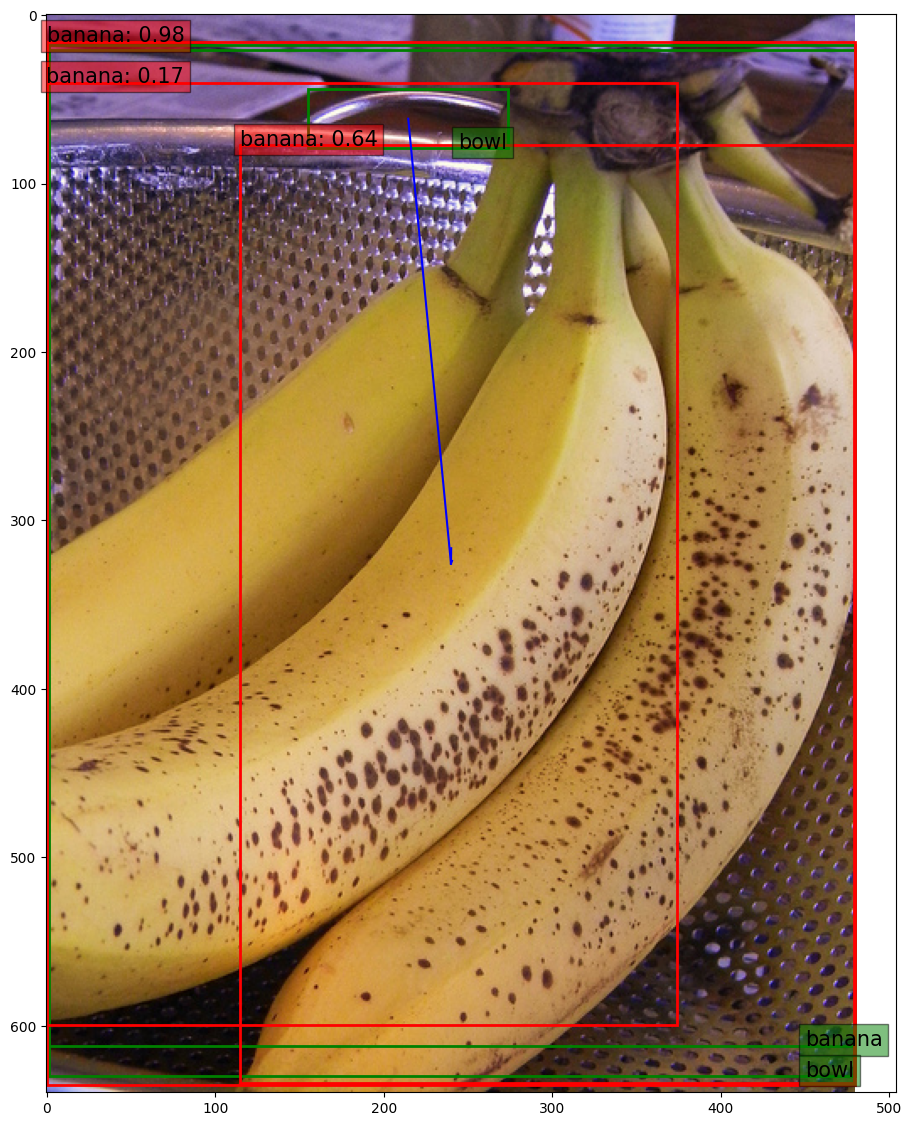

In [13]:
# plot true and predicted bounding boxes on an image "idx" and plot also the matchings
idx = 3


def plot_image_with_boxes(idx, preds):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    from PIL import Image

    img_path = preds.image_paths[idx]
    pred_boxes = preds.pred_boxes[idx]
    true_boxes = preds.true_boxes[idx]
    true_cls = preds.true_cls[idx]
    conf = preds.confidence[idx]
    cls_probas = preds.pred_cls[idx]

    confidence_threshold = preds.confidence_threshold

    keep = conf > confidence_threshold
    pred_boxes = pred_boxes[keep]
    cls_probas = cls_probas[keep]

    image = Image.open(img_path)
    plt.figure(figsize=(14, 14))
    plt.imshow(image)

    def draw_rect(ax, box, color, proba):
        """
        Draw a rectangle on the plot.

        Args:
            ax (object): Axes object of the plot.
            box (list): List of coordinates [x1, y1, x2, y2] of the rectangle.
            color (str): Color of the rectangle.
            proba (int or numpy.ndarray): Probability or probability distribution of the class.
        """
        x1, y1, x2, y2 = box
        ax.add_patch(
            plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2
            )
        )
        if isinstance(proba, int) or len(proba.shape) == 0:
            text = f"{DETRModel.COCO_CLASSES[proba]}" if proba >= 0 else "conf"
            ax.text(
                x2 - 30, y2, text, fontsize=15, bbox=dict(facecolor=color, alpha=0.5)
            )
        else:
            cl = proba.argmax()
            text = f"{DETRModel.COCO_CLASSES[cl]}: {proba[cl]:0.2f}"

            ax.text(x1, y1, text, fontsize=15, bbox=dict(facecolor=color, alpha=0.5))

    ax = plt.gca()
    for box, cl in zip(true_boxes, true_cls):
        draw_rect(ax, box, "green", cl)

    for box, prob in zip(pred_boxes, cls_probas):
        box = box.detach().cpu().numpy()
        draw_rect(ax, box, "red", prob)

    # plot matchings : lines between center of true_box and center of matching pred_box
    if preds.matching is not None:
        for i, j in enumerate(preds.matching[idx]):
            true_box = true_boxes[i].detach().cpu().numpy()
            pred_box = pred_boxes[j].detach().cpu().numpy()
            true_center = np.array(
                [(true_box[0] + true_box[2]) / 2, (true_box[1] + true_box[3]) / 2]
            )
            pred_center = np.array(
                [(pred_box[0] + pred_box[2]) / 2, (pred_box[1] + pred_box[3]) / 2]
            )
            # draw a line
            plt.plot(
                [true_center[0], pred_center[0]],
                [true_center[1], pred_center[1]],
                color="blue",
            )


plot_image_with_boxes(idx, preds_val)

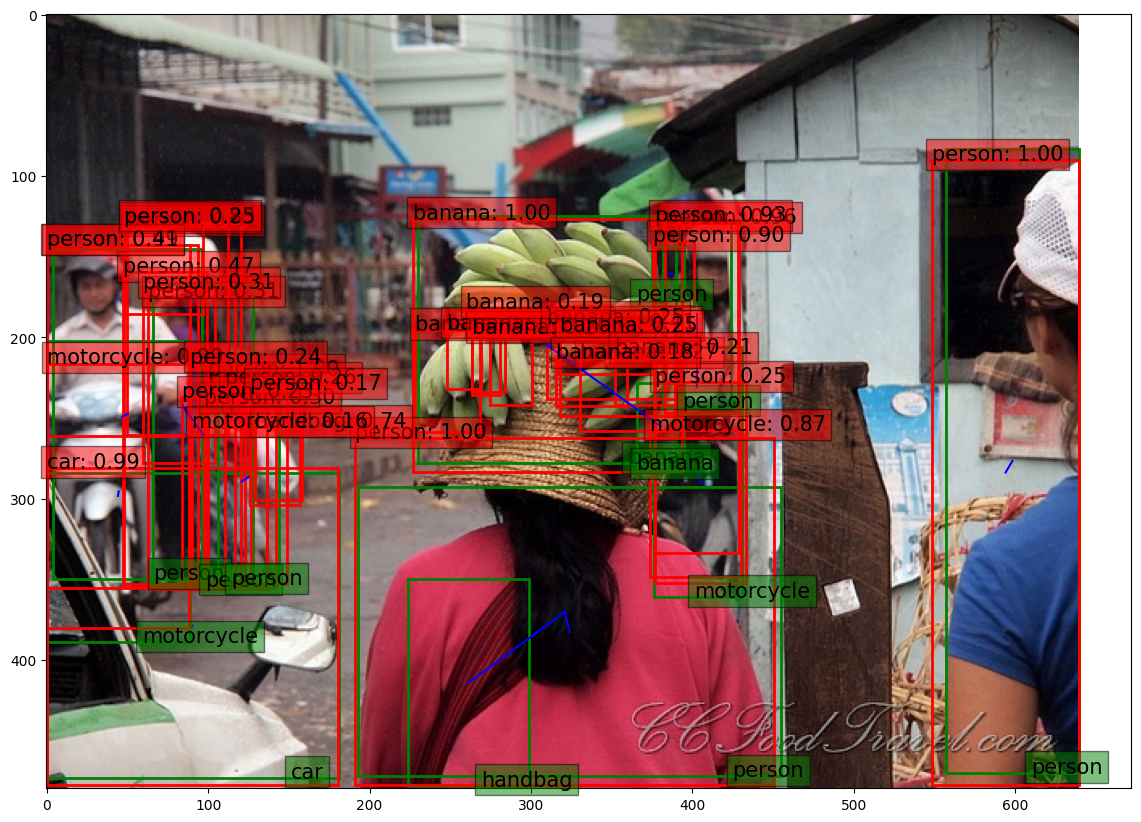

In [14]:
plot_image_with_boxes(2, preds_val)

2014


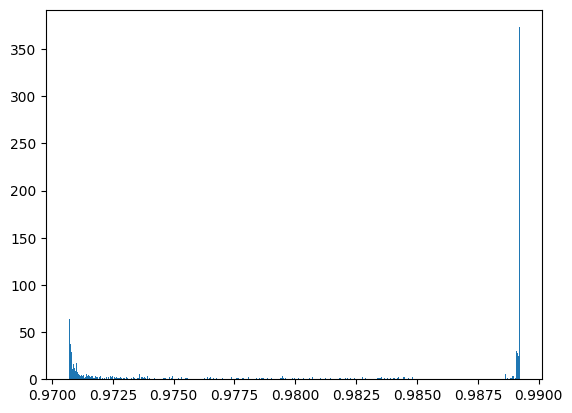

In [ ]:
import numpy as np

vals, counts = np.unique(score_cls_min.detach().cpu(), return_counts=True)
print(len(vals))
import matplotlib.pyplot as plt

plt.hist(score_cls_min.detach().cpu(), bins=2014)

In [ ]:
from cods.od.tr import ODToleranceRegion

odc = ODToleranceRegion(
    localization_loss="pixelwise",
    confidence_loss="box_number",
    classification_loss="lac",
    multiple_testing_correction="bonferroni",
    inequality="bernstein",
)
odc.calibrate(preds_cal, alpha=0.2, delta=0.1, bounds=[0, 1000])
conf_boxes, conf_cls = odc.conformalize(preds_val)
metrics = odc.evaluate(preds_val, conf_boxes, conf_cls)

  0%|          | 0/13 [00:00<?, ?it/s]


TypeError: ObjectnessLoss.__call__() takes 3 positional arguments but 4 were given

Using confidence threshold from preds


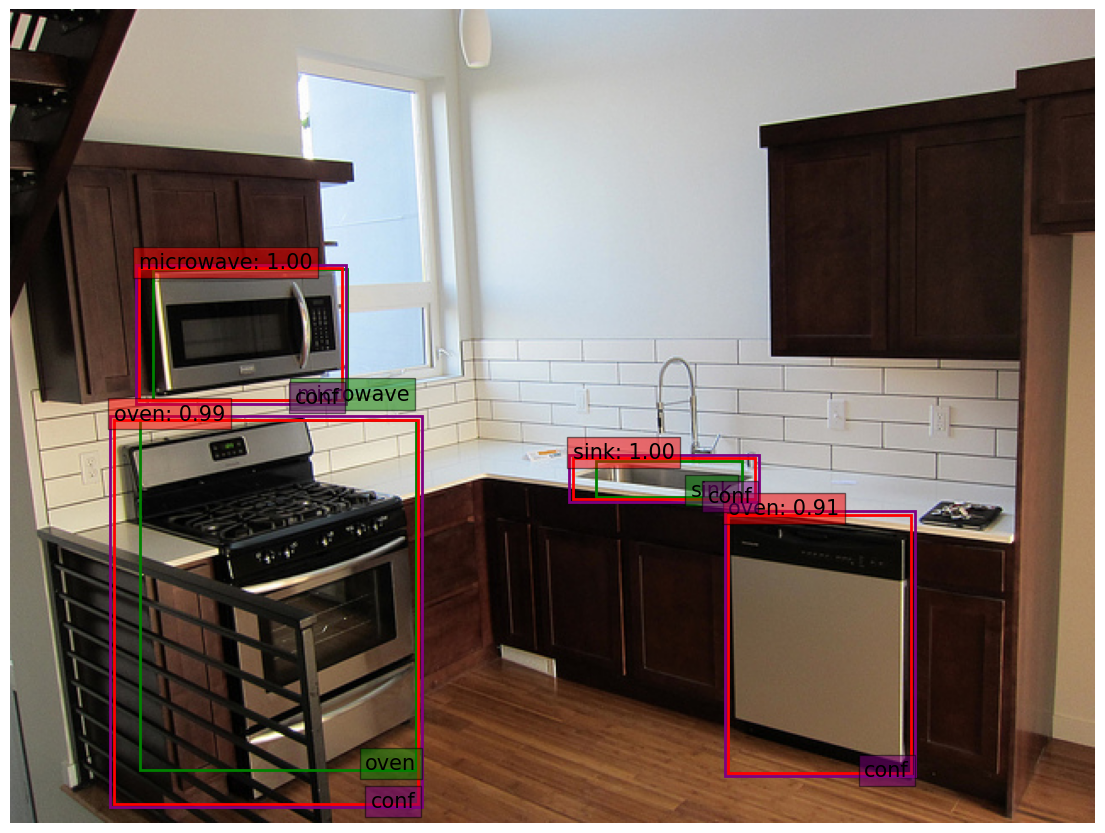

In [ ]:
from cods.od.visualization import plot_preds

plot_preds(preds_val, 10, conf_boxes=conf_boxes, conf_cls=conf_cls)

In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(od_preds=preds_val, conf_boxes=conf_boxes, conf_cls=conf_cls)

Defaulting to predictions' confidence threshold


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [01:53<00:00,  2.83s/it]                            


Average Precision: 0.7909144622488076


Average Recall = 0.005, Average Precision = 1.0: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]                            

(Conformalist) Average Precision: 0.7702853159101887
